In [5]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


--- Phần 1: Mô tả chi tiết dataset ---

1.1 Dataset về stress (Clean Stress Data)   
Nguồn gốc: Dataset "clean_stress_data.csv" chứa thông tin về nhân khẩu học, thói quen ngủ,hoạt động thể chất và các chỉ số sức khỏe để dự đoán rối loạn liên quan đến stress.  
Số features: 11 (Gender, Age, Occupation, Sleep Duration, Quality of Sleep, Physical Activity Level,Stress Level, BMI Category, Heart Rate, Daily Steps, Systolic BP, Diastolic BP)  
Ý nghĩa các lớp (dựa trên Sleep Disorder làm nhãn dự đoán):
- Sleep Apnea (Chứng ngưng thở khi ngủ):  
+Mô tả: Tình trạng hơi thở bị gián đoạn trong khi ngủ, thường kéo dài từ vài giây đến vài phút,có thể xảy ra nhiều lần trong đêm.  
+Liên quan đến stress: Stress cao có thể làm trầm trọng thêm tình trạng này, vì căng thẳng kích thích hệ thần kinh, ảnh hưởng đến hô hấp.  
+Yếu tố nguy cơ: Thừa cân/béo phì (BMI Category cao), huyết áp cao, nhịp tim bất thường, tuổi lớn.  
+Tác động: Gây mệt mỏi ban ngày, giảm chất lượng cuộc sống, tăng nguy cơ bệnh tim nếu không điều trị.  
- Insomnia (Mất ngủ):  
+Mô tả: Khó đi vào giấc ngủ, khó duy trì giấc ngủ, hoặc thức dậy quá sớm và không ngủ lại được, kéo dài ít nhất 3 đêm/tuần trong 3 tháng.  
+Liên quan đến stress: Mức stress cao (Stress Level cao) kích hoạt hệ thần kinh giao cảm, khiến tâm trí khó thư giãn, dẫn đến mất ngủ.  
+Yếu tố nguy cơ: Stress mãn tính, nghề nghiệp áp lực cao (ví dụ: Nurse, Salesperson), chất lượng giấc ngủ kém.  
+Tác động: Gây mệt mỏi, giảm tập trung, tăng nguy cơ lo âu và trầm cảm.  

In [6]:
# Đọc và tiền xử lý dữ liệu
stress_data = pd.read_csv('clean_data/cleaned_stress_data.csv')

# Xóa các cột không cần thiết nếu tồn tại
cols_to_drop = ['Person ID', 'index', 'Unnamed: 0']
stress_data = stress_data.drop(columns=[col for col in cols_to_drop if col in stress_data.columns])

# Kiểm tra giá trị null
print("\nKiểm tra giá trị null:")
print(stress_data.isnull().sum())

# Mã hóa các biến phân loại
# Gender: Male = 1, Female = 0
stress_data['Gender'] = stress_data['Gender'].map({'Male': 1, 'Female': 0})
if stress_data['Gender'].isnull().any():
    print("Cảnh báo: Có giá trị null trong Gender.")
    stress_data['Gender'].fillna(stress_data['Gender'].mode()[0], inplace=True)

# BMI Category: mã hóa về 0, 1, 2
stress_data['BMI Category'] = stress_data['BMI Category'].map({
    'Normal': 0, 'Normal Weight': 0, 'Overweight': 1, 'Obese': 2
})
if stress_data['BMI Category'].isnull().any():
    print("Cảnh báo: Có giá trị null trong BMI Category.")
    stress_data['BMI Category'].fillna(stress_data['BMI Category'].mode()[0], inplace=True)

# Stress Level Category: Low = 0, Medium = 1, High = 2
stress_data['Stress Level Category'] = stress_data['Stress Level Category'].map({
    'Low': 0, 'Medium': 1, 'High': 2
})
if stress_data['Stress Level Category'].isnull().any():
    print("Cảnh báo: Có giá trị null trong Stress Level Category.")
    stress_data['Stress Level Category'].fillna(stress_data['Stress Level Category'].mode()[0], inplace=True)

# Occupation: Label Encoding
le = LabelEncoder()
stress_data['Occupation'] = le.fit_transform(stress_data['Occupation'])
occupation_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nOccupation Mapping:", occupation_mapping)

# Tách cột Blood Pressure thành Systolic/Diastolic
bp_split = stress_data['Blood Pressure'].str.split('/', expand=True)
stress_data['Systolic BP'] = bp_split[0].astype(float)
stress_data['Diastolic BP'] = bp_split[1].astype(float)
stress_data.drop('Blood Pressure', axis=1, inplace=True)

# Kiểm tra kiểu dữ liệu
print("\nClean Stress Data Preview:")
print(stress_data.head())
print("\nData Types:")
print(stress_data.dtypes)

# Kiểm tra nếu còn cột nào chưa mã hóa đúng
for col in stress_data.columns:
    if col != 'Sleep Disorder' and stress_data[col].dtype not in [np.int64, np.float64]:
        print(f"Cảnh báo: Cột {col} chứa giá trị không phải số: {stress_data[col].unique()}")


Kiểm tra giá trị null:
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
Stress Level Category      0
dtype: int64

Occupation Mapping: {'Accountant': np.int64(0), 'Doctor': np.int64(1), 'Engineer': np.int64(2), 'Lawyer': np.int64(3), 'Nurse': np.int64(4), 'Sales Representative': np.int64(5), 'Salesperson': np.int64(6), 'Scientist': np.int64(7), 'Software Engineer': np.int64(8), 'Teacher': np.int64(9)}

Clean Stress Data Preview:
   Gender  Age  Occupation  Sleep Duration  Quality of Sleep  \
0       1   28           5             5.9                 4   
1       1   28           5             5.9                 4   
2       1   28           8             5.9                 4   
3       1  

--- Phần 2: Quy trình train/test, Decision Tree, đánh giá --


Stress Data - Train/Test 40/60:
Train shape: (62, 13) | Test shape: (93, 13)


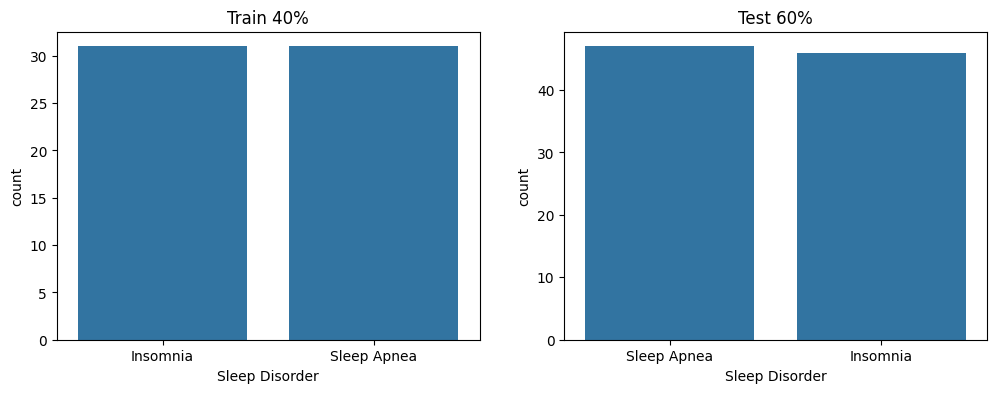


Stress Data - Train/Test 60/40:
Train shape: (93, 13) | Test shape: (62, 13)


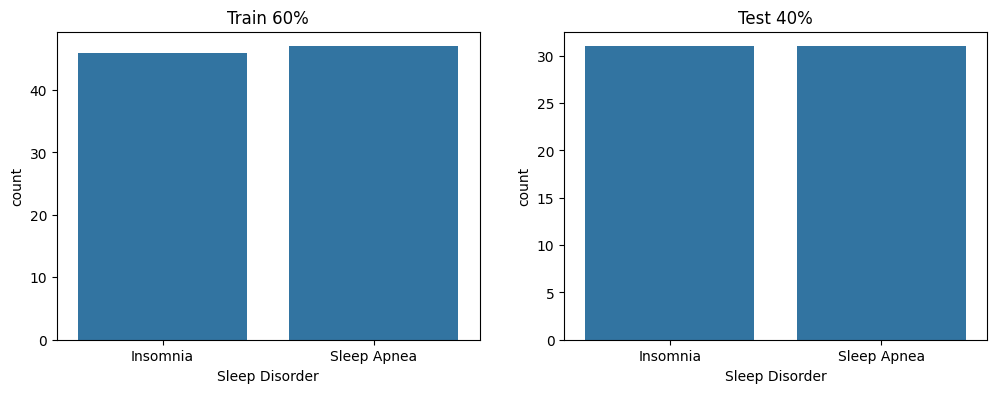


Stress Data - Train/Test 80/20:
Train shape: (124, 13) | Test shape: (31, 13)


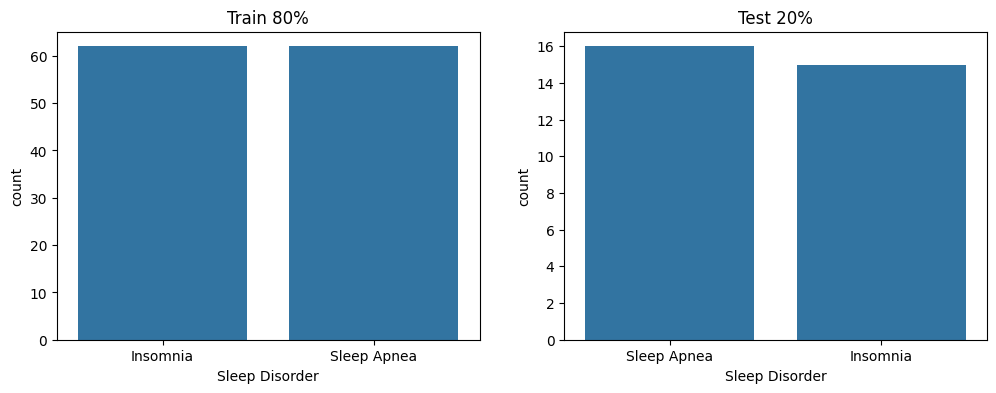


Stress Data - Train/Test 90/10:
Train shape: (139, 13) | Test shape: (16, 13)


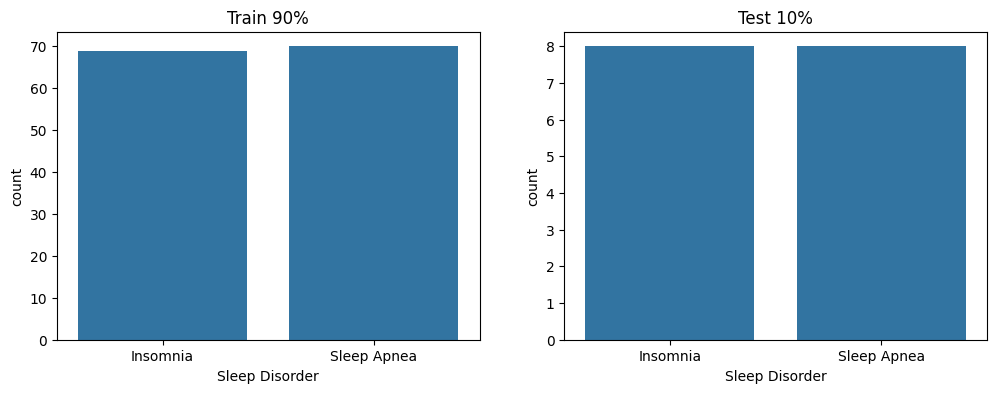


Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.88      0.93      0.90        15
 Sleep Apnea       0.93      0.88      0.90        16

    accuracy                           0.90        31
   macro avg       0.90      0.90      0.90        31
weighted avg       0.91      0.90      0.90        31

Confusion Matrix:
[[14  1]
 [ 2 14]]

Accuracy theo max_depth:
  max_depth  Train Accuracy  Test Accuracy
0      None        0.967742       0.903226
1         2        0.935484       0.870968
2         3        0.935484       0.870968
3         4        0.959677       0.870968
4         5        0.967742       0.903226
5         6        0.967742       0.903226
6         7        0.967742       0.903226


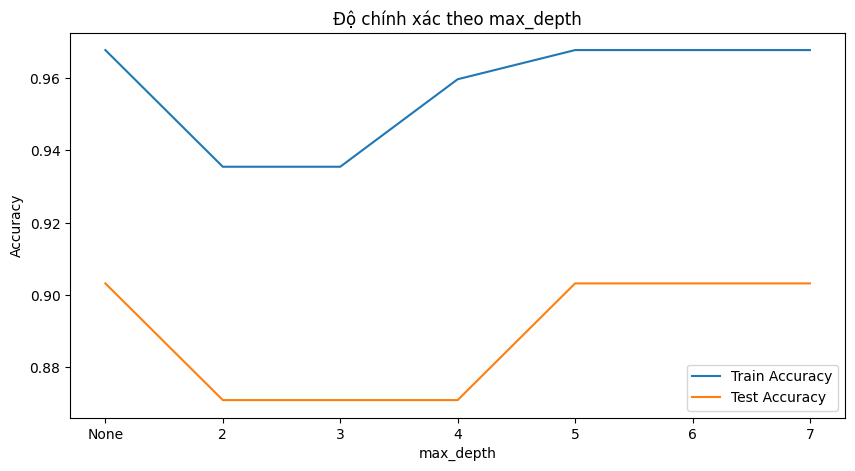

Optimal max_depth = 5, Test Accuracy = 0.9032
Số node: 25, Độ sâu: 5


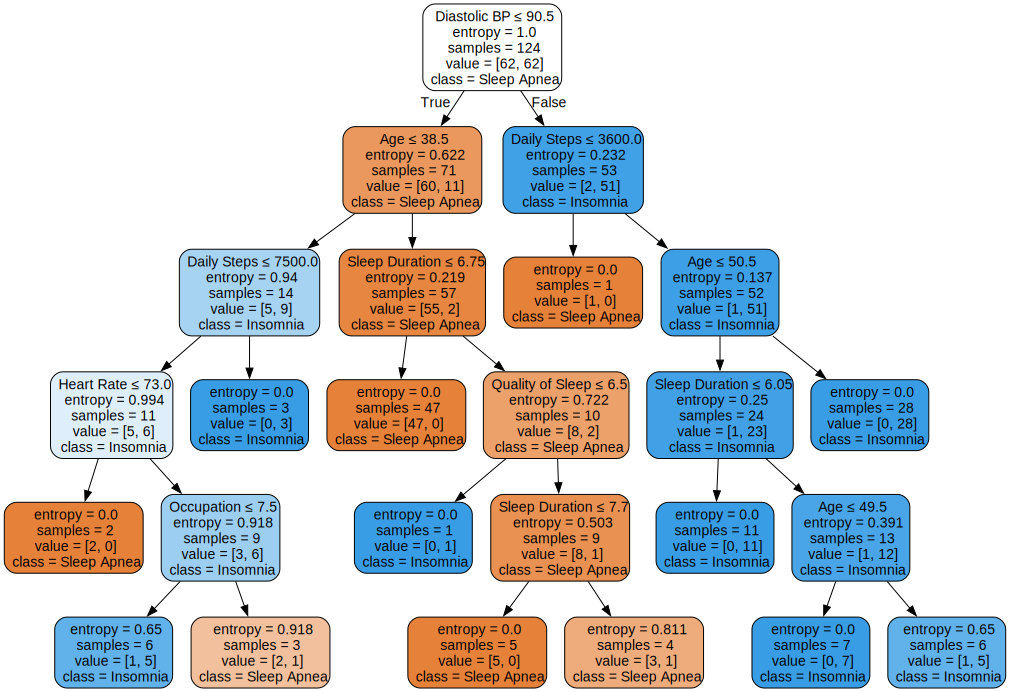

In [7]:
# Khảo sát các tỉ lệ train/test khác nhau
ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
X = stress_data.drop('Sleep Disorder', axis=1)
y = stress_data['Sleep Disorder']

for train_ratio, test_ratio in ratios:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, stratify=y, random_state=42
    )
    print(f"\nStress Data - Train/Test {int(train_ratio*100)}/{int(test_ratio*100)}:")
    print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

    # Vẽ phân phối lớp
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title(f'Train {int(train_ratio*100)}%')

    plt.subplot(1, 2, 2)
    sns.countplot(x=y_test)
    plt.title(f'Test {int(test_ratio*100)}%')
    plt.show()

# Dùng tỉ lệ 80/20 để train và đánh giá
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train mô hình Decision Tree
try:
    start_time = time.time()
    dt = DecisionTreeClassifier(criterion="entropy", random_state=42)
    dt.fit(X_train, y_train)
    train_time = time.time() - start_time
except ValueError as e:
    print("Lỗi khi huấn luyện mô hình:", e)
    raise

# Đánh giá mô hình
y_pred = dt.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Khảo sát các giá trị max_depth khác nhau
max_depths = [None, 2, 3, 4, 5, 6, 7]
results = []
for depth in max_depths:
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    results.append({
        'max_depth': 'None' if depth is None else depth,
        'Train Accuracy': dt.score(X_train, y_train),
        'Test Accuracy': dt.score(X_test, y_test)
    })

results_df = pd.DataFrame(results)
print("\nAccuracy theo max_depth:")
print(results_df)

# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(10, 5))
plt.plot(results_df['max_depth'].astype(str), results_df['Train Accuracy'], label='Train Accuracy')
plt.plot(results_df['max_depth'].astype(str), results_df['Test Accuracy'], label='Test Accuracy')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Độ chính xác theo max_depth")
plt.legend()
plt.show()

# Chọn max_depth tối ưu
max_test_acc = results_df['Test Accuracy'].max()
best_rows = results_df[results_df['Test Accuracy'] == max_test_acc]
best_rows_filtered = best_rows[best_rows['max_depth'] != 'None']
best_depth = int(best_rows_filtered['max_depth'].min()) if not best_rows_filtered.empty else None
print(f"Optimal max_depth = {best_depth!r}, Test Accuracy = {max_test_acc:.4f}")

# Train lại với độ sâu tối ưu
dt_opt = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth, random_state=42)
dt_opt.fit(X_train, y_train)
tree_nodes = dt_opt.tree_.node_count
tree_depth = dt_opt.tree_.max_depth
print(f"Số node: {tree_nodes}, Độ sâu: {tree_depth}")

# Export cây quyết định
dot_opt = export_graphviz(
    dt_opt,
    out_file=None,
    feature_names=X.columns,
    class_names=stress_data['Sleep Disorder'].unique(),
    filled=True,
    rounded=True,
    special_characters=True
)
graph_opt = graphviz.Source(dot_opt)
graph_opt.render("id3_tree/stress_data_tree_opt")  # Lưu file PDF
graph_opt  # Hiển thị cây 
